# Bussiness problem

Context

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.
Therefor we will predicting Heart Disease using Classification ML Algos.

## Import Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pandas_profiling
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
import catboost
import optuna
plt.style.use('ggplot')
#Module related to VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Moudles related to feature selection
from sklearn.feature_selection import RFE,SelectKBest,f_classif
#Modules related key techniques of supervised learning 
import statsmodels.formula.api as smf

## Create UDFs

In [2]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [3]:
# missingg imputating.
def missing_imputing(x):
    if (x.dtypes=='float64') | (x.dtypes=='int64'):
        x=x.fillna(x.median())
    else:
        x=x.fillna(x.mode()[0])
    return x

## Import Data

In [4]:
df=pd.read_csv('D:/E-pi/ML/Classification/heart.csv')
df

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193          1     Normal   
915   57   M           ASY        130          131          0     Normal   
916   57   F           ATA        130          236          0        LVH   
917   38   M           NAP        138          175          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0      172              N      0.0       Up             0  
1      156              N      1.0     Flat             1  
2       98              N      0.0       Up             0  
3      108              Y      1.5     Flat             1  
4      122              N      0.0       Up             0  
..     ...            ...      ...      ...           ...  
913    132              N      1.2     Flat             1  
914    141              N      3.4     Flat             1  
915    115              Y      1.2     Flat             1  
916    174              N      0.0     Flat             1  
917    173              N      0.0       Up             0  

[918 rows x 12 columns]

## Data Inspection

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
# Convert Target feature (HeartDisease ) and FastingBsto object dtype.
df['HeartDisease']=df['HeartDisease'].apply(str)
df['FastingBS']=df['FastingBS'].apply(str)

In [8]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS          object
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease       object
dtype: object

##### There are no null values in Data but from profilling report seems there are alot of zeros values in Cholesterol & one zero value in RestingBP.

In [9]:
df.Cholesterol.replace(0,np.nan,inplace=True)

In [10]:
df.Cholesterol.isnull().sum()

172

In [11]:
df=df.apply(missing_imputing)

In [12]:
df.Cholesterol.isnull().sum()

0

In [13]:
# Check duplicates 
df.duplicated().sum()

0

##### There are no duplicates in the Data.

In [14]:
# Check the balance of the labels.
df.HeartDisease.value_counts(normalize=True)

1    0.553377
0    0.446623
Name: HeartDisease, dtype: float64

##### The Dataset is Balanced.

In [15]:
for i in df.columns:
    print(df[i].value_counts())
    print('------------------------------------------------------------------------------------------------')

54    51
58    42
55    41
56    38
57    38
52    36
51    35
59    35
62    35
53    33
60    32
48    31
61    31
63    30
50    25
46    24
41    24
43    24
64    22
65    21
49    21
47    19
44    19
42    18
45    18
38    16
67    15
39    15
66    13
69    13
40    13
35    11
37    11
68    10
34     7
74     7
70     7
36     6
71     5
32     5
72     4
29     3
75     3
33     2
77     2
76     2
31     2
30     1
28     1
73     1
Name: Age, dtype: int64
------------------------------------------------------------------------------------------------
M    725
F    193
Name: Sex, dtype: int64
------------------------------------------------------------------------------------------------
ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64
------------------------------------------------------------------------------------------------
120    132
130    118
140    107
110     58
150     55
      ... 
185      1
98       1
92       1
113      1
164  

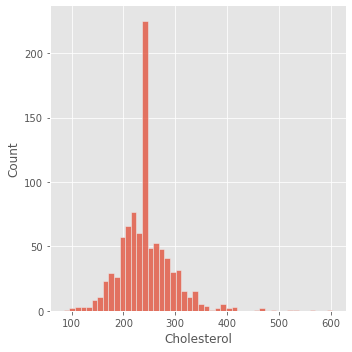

In [16]:
sns.displot(data=df,x='Cholesterol')
plt.show()

###### the data is little skewed so i will use median instead of mean.

In [17]:
# Check the zero value of RestingBP feature.
df[df.RestingBP==0]

Age Sex ChestPainType  RestingBP  Cholesterol FastingBS RestingECG  \
449   55   M           NAP          0        237.0         0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope HeartDisease  
449    155              N      1.5     Flat            1

In [18]:
df.drop(index=449,inplace=True)

In [19]:
df.reset_index()

index  Age Sex ChestPainType  RestingBP  Cholesterol FastingBS  \
0        0   40   M           ATA        140        289.0         0   
1        1   49   F           NAP        160        180.0         0   
2        2   37   M           ATA        130        283.0         0   
3        3   48   F           ASY        138        214.0         0   
4        4   54   M           NAP        150        195.0         0   
..     ...  ...  ..           ...        ...          ...       ...   
912    913   45   M            TA        110        264.0         0   
913    914   68   M           ASY        144        193.0         1   
914    915   57   M           ASY        130        131.0         0   
915    916   57   F           ATA        130        236.0         0   
916    917   38   M           NAP        138        175.0         0   

    RestingECG  MaxHR ExerciseAngina  Oldpeak ST_Slope HeartDisease  
0       Normal    172              N      0.0       Up            0  
1       Normal    156              N      1.0     Flat            1  
2           ST     98              N      0.0       Up            0  
3       Normal    108              Y      1.5     Flat            1  
4       Normal    122              N      0.0       Up            0  
..         ...    ...            ...      ...      ...          ...  
912     Normal    132              N      1.2     Flat            1  
913     Normal    141              N      3.4     Flat            1  
914     Normal    115              Y      1.2     Flat            1  
915        LVH    174              N      0.0     Flat            1  
916     Normal    173              N      0.0       Up            0  

[917 rows x 13 columns]

-------------------------------------------------------------------------------------------------------------------------------

In [20]:
# split data to continous and categorical varaiables.
num_var=df.select_dtypes(include=['float64','int64'])
cat_var=df.select_dtypes(['object'])

In [21]:
num_var.apply(continuous_var_summary).round(1)

Age  RestingBP  Cholesterol     MaxHR  Oldpeak
N         917.0      917.0        917.0     917.0    917.0
NMISS       0.0        0.0          0.0       0.0      0.0
SUM     49068.0   121540.0     223025.0  125436.0    813.1
MEAN       53.5      132.5        243.2     136.8      0.9
MEDIAN     54.0      130.0        237.0     138.0      0.6
STD         9.4       18.0         53.4      25.5      1.1
VAR        89.1      324.0       2854.8     648.6      1.1
MIN        28.0       80.0         85.0      60.0     -2.6
P1         32.0       95.2        129.3      77.2     -0.5
P5         37.0      107.6        168.0      96.0      0.0
P10        40.0      110.0        186.0     103.0      0.0
P25        47.0      120.0        214.0     120.0      0.0
P50        54.0      130.0        237.0     138.0      0.6
P75        60.0      140.0        267.0     156.0      1.5
P90        65.0      160.0        305.0     170.0      2.3
P95        68.0      160.0        331.4     178.0      3.0
P99        74.0      180.0        411.5     186.0      4.0
MAX        77.0      200.0        603.0     202.0      6.2

In [22]:
cat_var.describe(include=['O'])

Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope  \
count   917           917       917        917            917      917   
unique    2             4         2          3              2        3   
top       M           ASY         0     Normal              N     Flat   
freq    724           496       703        551            546      459   

       HeartDisease  
count           917  
unique            2  
top               1  
freq            507

------------------------------------------------------------------------------------------------------------------------------

### Outlier treatment

In [23]:
q1=df.quantile(0.25)
q3=df.quantile(0.75)
iqr=q3-q1

In [24]:
# Data loss
dataloss=((917-836)/917)*100
dataloss

8.833151581243184

### i tried to use IQR but i will lose  around 9% of the Data and the data is not huge so i will use p.cut technique

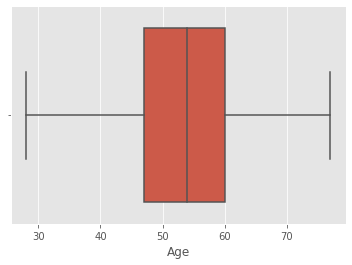

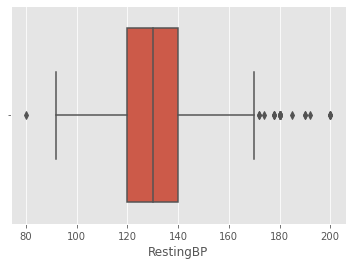

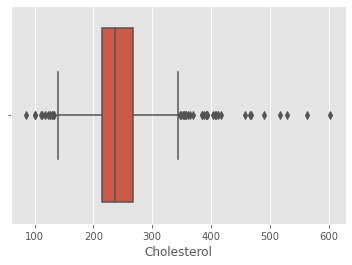

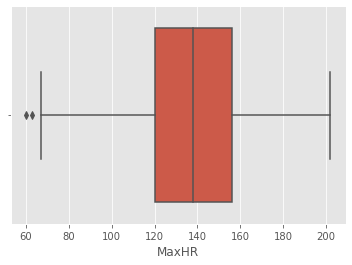

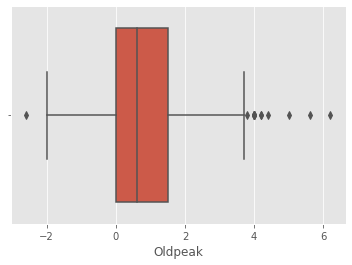

In [25]:
for col in num_var.columns:
    sns.boxplot(num_var[col])
    plt.show()

In [26]:
num_var = num_var.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

In [27]:
num_var.apply(continuous_var_summary).round(2)

Age  RestingBP  Cholesterol      MaxHR  Oldpeak
N         917.00     917.00       917.00     917.00   917.00
NMISS       0.00       0.00         0.00       0.00     0.00
SUM     49072.00  121444.60    222378.40  125461.60   814.60
MEAN       53.51     132.44       242.51     136.82     0.89
MEDIAN     54.00     130.00       237.00     138.00     0.60
STD         9.36      17.54        49.01      25.13     1.03
VAR        87.60     307.68      2401.66     631.46     1.06
MIN        32.00      95.16       129.32      77.16    -0.50
P1         32.00      95.29       129.59      77.29    -0.50
P5         37.00     107.60       168.00      96.00     0.00
P10        40.00     110.00       186.00     103.00     0.00
P25        47.00     120.00       214.00     120.00     0.00
P50        54.00     130.00       237.00     138.00     0.60
P75        60.00     140.00       267.00     156.00     1.50
P90        65.00     160.00       305.00     170.00     2.30
P95        68.00     160.00       331.40     178.00     3.00
P99        74.00     180.00       411.12     186.00     4.00
MAX        74.00     180.00       411.52     186.00     4.00

In [28]:
num_var.skew()

Age           -0.190059
RestingBP      0.474164
Cholesterol    0.750380
MaxHR         -0.114971
Oldpeak        0.967838
dtype: float64

In [29]:
df_final = pd.concat([num_var, cat_var],axis=1)

In [30]:
df_final.head()

Age  RestingBP  Cholesterol  MaxHR  Oldpeak Sex ChestPainType FastingBS  \
0  40.0      140.0        289.0  172.0      0.0   M           ATA         0   
1  49.0      160.0        180.0  156.0      1.0   F           NAP         0   
2  37.0      130.0        283.0   98.0      0.0   M           ATA         0   
3  48.0      138.0        214.0  108.0      1.5   F           ASY         0   
4  54.0      150.0        195.0  122.0      0.0   M           NAP         0   

  RestingECG ExerciseAngina ST_Slope HeartDisease  
0     Normal              N       Up            0  
1     Normal              N     Flat            1  
2         ST              N       Up            0  
3     Normal              Y     Flat            1  
4     Normal              N       Up            0

# EDA

### Univariate analysis

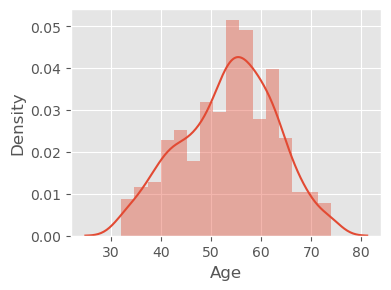

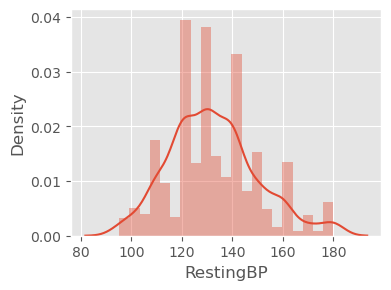

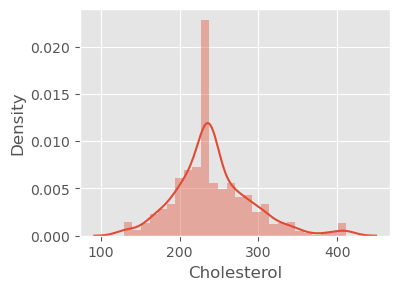

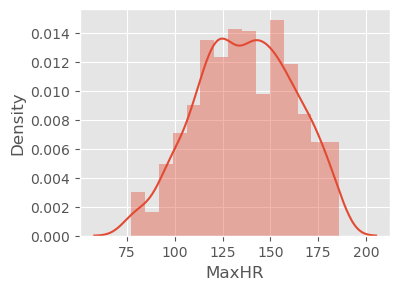

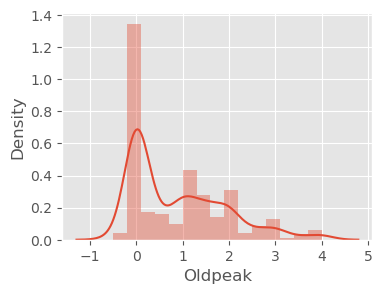

In [31]:
for col in num_var.columns:
    plt.figure(figsize=(4,3),dpi=100)
    sns.distplot(df_final[col])
    plt.show()

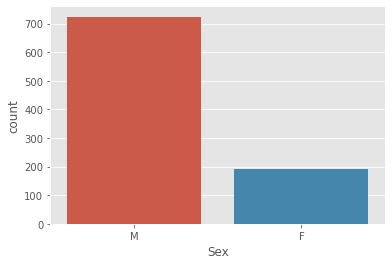

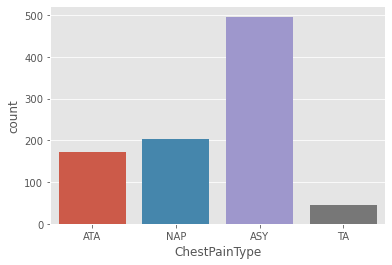

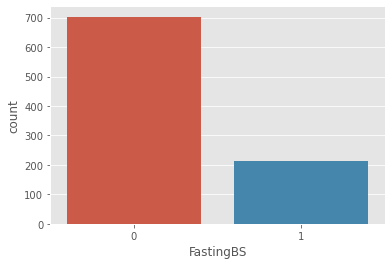

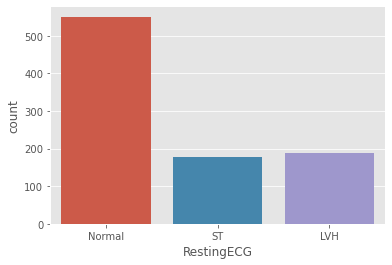

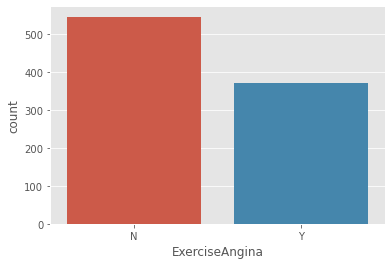

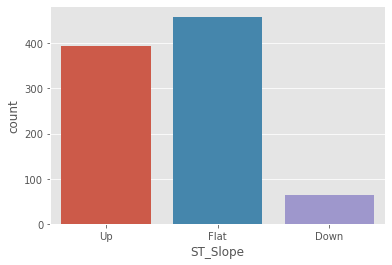

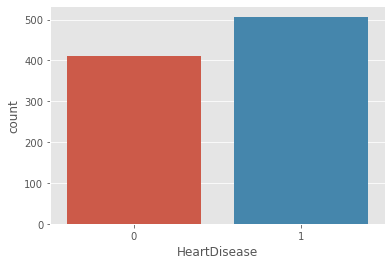

In [32]:
for i in cat_var.columns:
    sns.countplot(data=df_final,x=i)
    plt.xlabel(str(i))
    plt.show()

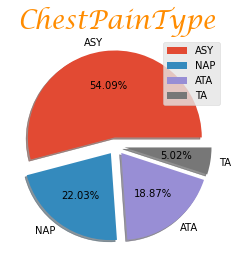

In [33]:
ax=df_final['ChestPainType'].value_counts().plot.pie(explode=[0.1,0.1,0.1,0.1],autopct='%1.2f%%',shadow=True)
ax.set_title(label='ChestPainType',fontsize=25,color='DarkOrange',font='Lucida Calligraphy')
plt.legend(labels=['ASY','NAP','ATA','TA'],loc='upper right')
plt.axis('off');

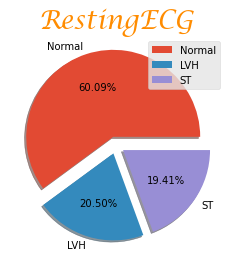

In [34]:
ax=df_final['RestingECG'].value_counts().plot.pie(explode=[0.1,0.1,0.1],autopct='%1.2f%%',shadow=True)
ax.set_title(label='RestingECG',fontsize=25,color='DarkOrange',font='Lucida Calligraphy')
plt.legend(labels=['Normal','LVH','ST'],loc='upper right')
plt.axis('off');

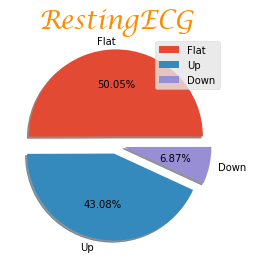

In [35]:
ax=df_final['ST_Slope'].value_counts().plot.pie(explode=[0.1,0.1,0.1],autopct='%1.2f%%',shadow=True)
ax.set_title(label='RestingECG',fontsize=25,color='DarkOrange',font='Lucida Calligraphy')
plt.legend(labels=['Flat','Up','Down'],loc='upper right')
plt.axis('off');

-------------------------------------------------------------------------------------------------------------------------------

#### Bivariate analysis

In [36]:
fig=px.histogram(df_final,x='Sex',color='HeartDisease',width=400,height=400)
fig.show()

In [37]:
fig=px.histogram(df_final,x='ST_Slope',color='HeartDisease',width=400,height=400)
fig.show()

In [38]:
fig=px.histogram(df_final,x='ChestPainType',color='HeartDisease',width=400,height=400)
fig.show()

In [39]:

fig=px.histogram(df_final,x='ExerciseAngina',color='HeartDisease',width=400,height=400)
fig.show()

In [40]:
fig=px.histogram(df_final,x='RestingECG',color='HeartDisease',width=400,height=400)
fig.show()

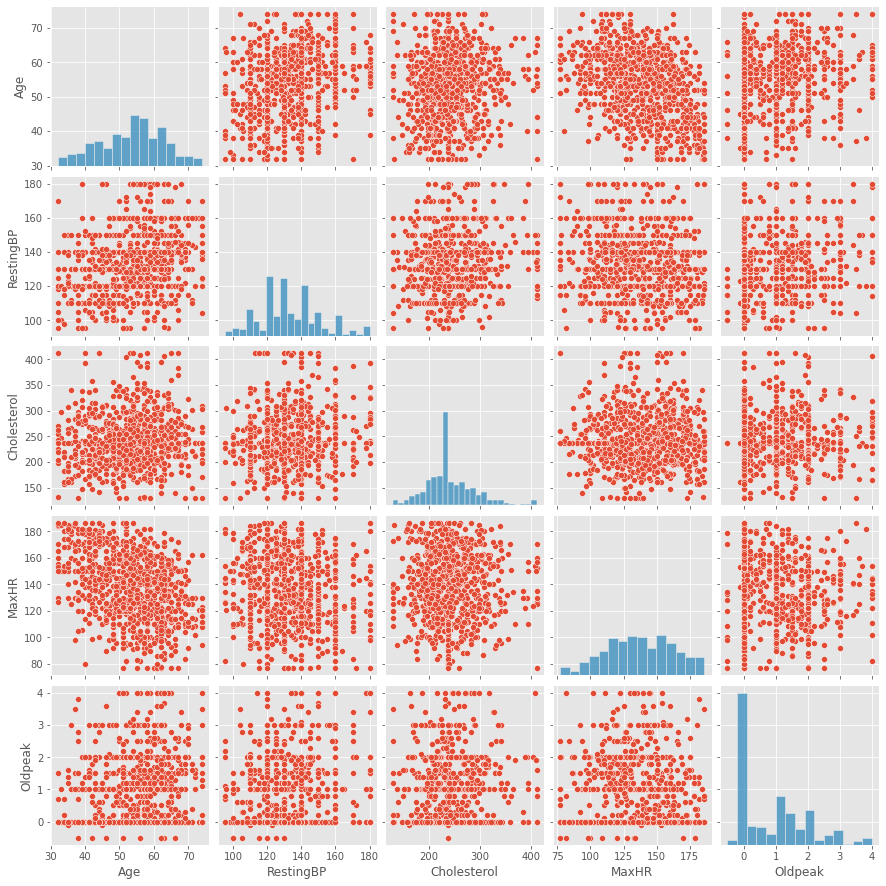

In [41]:
sns.pairplot(df_final)
plt.show()

-------------------------------------------------------------------------------------------------------------------------------

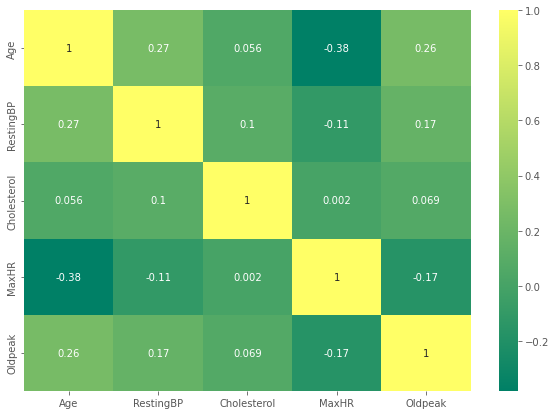

In [42]:
# heatmap
plt.figure(figsize = (10,7))
sns.heatmap(df_final.corr(), annot=True,cmap='summer')
plt.show()

In [43]:
# Insights from above plots

# --> Data contain about 78.95% of men and 21.05% women.
# --> ASY is the most dominant in ChestPainType with 54.09%  and TA is the least one.
# --> More than 85% of records that have ExerciseAngina have Heart disease.
# --> Men are almost 2.44 times more likely have a heart disease than women
# --> Person with ASY has almost 6 times more likely have heart disease than person with ATA.
# -->  ST_slope UP has significantly lees likely has heart disease than other two segment.
# -->  Age and MaxHR have good negative correlation.

In [44]:
# get_dummies for categorical features
data_final = pd.get_dummies(df_final, columns = cat_var.columns,  drop_first=True)

In [45]:
data_final.head()

Age  RestingBP  Cholesterol  MaxHR  Oldpeak  Sex_M  ChestPainType_ATA  \
0  40.0      140.0        289.0  172.0      0.0      1                  1   
1  49.0      160.0        180.0  156.0      1.0      0                  0   
2  37.0      130.0        283.0   98.0      0.0      1                  1   
3  48.0      138.0        214.0  108.0      1.5      0                  0   
4  54.0      150.0        195.0  122.0      0.0      1                  0   

   ChestPainType_NAP  ChestPainType_TA  FastingBS_1  RestingECG_Normal  \
0                  0                 0            0                  1   
1                  1                 0            0                  1   
2                  0                 0            0                  0   
3                  0                 0            0                  1   
4                  1                 0            0                  1   

   RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  ST_Slope_Up  HeartDisease_1  
0              0                 0              0            1               0  
1              0                 0              1            0               1  
2              1                 0              0            1               0  
3              0                 1              1            0               1  
4              0                 0              0            1               0

In [46]:
data_final.shape

(917, 16)

-------------------------------------------------------------------------------------------------------------------------------

### Feature Reduction

##### Weight of evidence & information value

In [47]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [48]:
for col in data_final.columns:
    if col == 'HeartDisease_1': continue
    else:
        print('WoE and IV for column: {}'.format(col))
        df, iv = calculate_woe_iv(data_final, col, 'HeartDisease_1')
       # print(df)
        print('IV score: {:.2f}'.format(iv))
        print('\n')

WoE and IV for column: Age
IV score: 0.61


WoE and IV for column: RestingBP
IV score: 0.24


WoE and IV for column: Cholesterol
IV score: 0.85


WoE and IV for column: MaxHR
IV score: 0.64


WoE and IV for column: Oldpeak
IV score: 0.89


WoE and IV for column: Sex_M
IV score: 0.40


WoE and IV for column: ChestPainType_ATA
IV score: 0.77


WoE and IV for column: ChestPainType_NAP
IV score: 0.19


WoE and IV for column: ChestPainType_TA
IV score: 0.01


WoE and IV for column: FastingBS_1
IV score: 0.33


WoE and IV for column: RestingECG_Normal
IV score: 0.03


WoE and IV for column: RestingECG_ST
IV score: 0.04


WoE and IV for column: ExerciseAngina_Y
IV score: 1.16


WoE and IV for column: ST_Slope_Flat
IV score: 1.41


WoE and IV for column: ST_Slope_Up
IV score: 1.82




In [49]:
l1_iv=data_final.columns.difference(['HeartDisease_1','ChestPainType_TA','RestingECG_Normal'])

In [50]:
l1_iv

Index(['Age', 'ChestPainType_ATA', 'ChestPainType_NAP', 'Cholesterol',
       'ExerciseAngina_Y', 'FastingBS_1', 'MaxHR', 'Oldpeak', 'RestingBP',
       'RestingECG_ST', 'ST_Slope_Flat', 'ST_Slope_Up', 'Sex_M'],
      dtype='object')

------------------------------------------------------------------------------------------------------------------------------

#### RFE

In [51]:
X = data_final[data_final.columns.difference(['HeartDisease_1'])]
y = data_final.HeartDisease_1

In [52]:
rfe = RFE(RandomForestClassifier(), n_features_to_select=9).fit(X,y)

In [53]:

l2_rfe = X.columns[rfe.get_support()]

In [54]:
l2_rfe

Index(['Age', 'Cholesterol', 'ExerciseAngina_Y', 'MaxHR', 'Oldpeak',
       'RestingBP', 'ST_Slope_Flat', 'ST_Slope_Up', 'Sex_M'],
      dtype='object')

#### SelectKbest

In [55]:
SKB = SelectKBest(f_classif, k=9).fit(X, y )

In [56]:
l3_skb = X.columns[SKB.get_support()]

In [57]:
l3_skb

Index(['Age', 'ChestPainType_ATA', 'ExerciseAngina_Y', 'FastingBS_1', 'MaxHR',
       'Oldpeak', 'ST_Slope_Flat', 'ST_Slope_Up', 'Sex_M'],
      dtype='object')

------------------------------------------------------------------------------------------------------------------------------

In [58]:
list(set(list(l1_iv)+list(l2_rfe)+list(l3_skb)))

['ST_Slope_Up',
 'FastingBS_1',
 'ExerciseAngina_Y',
 'Sex_M',
 'ChestPainType_NAP',
 'Oldpeak',
 'MaxHR',
 'Cholesterol',
 'RestingBP',
 'ST_Slope_Flat',
 'Age',
 'RestingECG_ST',
 'ChestPainType_ATA']

##### VIF check Multicollinarity

In [75]:
Final_list = ['ST_Slope_Up',
 'FastingBS_1',
 'ExerciseAngina_Y',
 'Sex_M',
 'ChestPainType_NAP',
 'Oldpeak',
 'ST_Slope_Flat',
 'RestingECG_ST',
 'ChestPainType_ATA']

In [76]:
X_new = X[Final_list]
y = y

In [77]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif["features"] = X_new.columns

In [78]:
vif.sort_values(by='VIF_Factor', ascending=False, inplace=True)
vif

VIF_Factor           features
3    4.321662              Sex_M
6    3.401587      ST_Slope_Flat
0    3.030462        ST_Slope_Up
2    2.377202   ExerciseAngina_Y
5    2.134101            Oldpeak
8    1.619662  ChestPainType_ATA
4    1.446243  ChestPainType_NAP
1    1.351752        FastingBS_1
7    1.272412      RestingECG_ST

#### Static Model

In [79]:
data_model = pd.concat([X_new, y], axis=1)

In [80]:
X_new.columns

Index(['ST_Slope_Up', 'FastingBS_1', 'ExerciseAngina_Y', 'Sex_M',
       'ChestPainType_NAP', 'Oldpeak', 'ST_Slope_Flat', 'RestingECG_ST',
       'ChestPainType_ATA'],
      dtype='object')

In [81]:
# split the data into train and test
train,test=train_test_split(data_model,test_size=0.25,random_state=12,shuffle=True)

In [82]:
print('train size: ',train.shape)
print('---------------------------')
print('test size: ',test.shape)

train size:  (687, 10)
---------------------------
test size:  (230, 10)


In [83]:
 #Logistic Regression

eqn = 'HeartDisease_1~ '+'+'.join(X_new.columns)

In [84]:
model_logit=smf.logit(eqn,data=train).fit()
print(model_logit.summary())

Optimization terminated successfully.
         Current function value: 0.341366
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         HeartDisease_1   No. Observations:                  687
Model:                          Logit   Df Residuals:                      677
Method:                           MLE   Df Model:                            9
Date:                Sat, 29 Oct 2022   Pseudo R-squ.:                  0.5037
Time:                        15:50:23   Log-Likelihood:                -234.52
converged:                       True   LL-Null:                       -472.52
Covariance Type:            nonrobust   LLR p-value:                 7.895e-97
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.2143      0.589     -2.060      0.039      -2.370      -0.059
ST_Slope

In [85]:
train_pred = model_logit.predict(train)
test_pred = model_logit.predict(test)

In [86]:
print('train_auc', roc_auc_score(train.HeartDisease_1, train_pred))
print('test_auc', roc_auc_score(test.HeartDisease_1, test_pred))

train_auc 0.9261941883973547
test_auc 0.9168964460784313


-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

In [91]:
features=X[['ST_Slope_Flat',
 'ST_Slope_Up',
 'Cholesterol',
 'Oldpeak',
 'ExerciseAngina_Y',
 'Sex_M',
 'FastingBS_1',
 'ChestPainType_ATA',
 'ChestPainType_NAP']]

#### Spliting the Data

In [87]:
x_train,x_test,y_train,y_test=train_test_split(X_new,y,test_size=0.25,random_state=12,shuffle=True)

In [88]:
sc=StandardScaler()
x_train_sc=sc.fit_transform(x_train)
x_test_sc=sc.transform(x_test)

### ML ALGOS

In [89]:
lr=LogisticRegression()
lr.fit(x_train_sc,y_train)

LogisticRegression()

In [90]:
pred_train=lr.predict(x_train_sc)
pred_test=lr.predict(x_test_sc)

In [91]:
print('The roc_auc_score value is: ', roc_auc_score(y_train,pred_train))

The roc_auc_score value is:  0.8592630983791933


In [92]:
print('The roc_auc_score value is: ', roc_auc_score(y_test,pred_test))

The roc_auc_score value is:  0.8629748774509803


In [93]:
print(confusion_matrix(y_test,pred_test))

[[ 86  16]
 [ 15 113]]


In [94]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       102
           1       0.88      0.88      0.88       128

    accuracy                           0.87       230
   macro avg       0.86      0.86      0.86       230
weighted avg       0.87      0.87      0.87       230



#### Best cutt-off

In [95]:
train['pred_prob'] = train_pred
test['pred_prob'] = test_pred

In [96]:
# Getting highest sensitivity+specificity
roc_df = pd.DataFrame()
for cut_off in np.linspace(0,1):
  
    train['y_pred'] = np.where(train.pred_prob>cut_off, 1, 0)
    train['TP'] = np.where(((train.HeartDisease_1 ==1) & (train.y_pred==1)), 1, 0)
    train['TN'] = np.where(((train.HeartDisease_1 ==0) & (train.y_pred==0)), 1, 0)
    train['FP'] = np.where(((train.HeartDisease_1 ==0) & (train.y_pred==1)), 1, 0)
    train['FN'] = np.where(((train.HeartDisease_1 ==1) & (train.y_pred==0)), 1, 0)
    sensitivity = train.TP.sum()/train.HeartDisease_1.sum()
    specificity = train.TN.sum()/(1-train.HeartDisease_1).sum()
    accuracy = (train.TN.sum()+train.TP.sum())/train.HeartDisease_1.count()
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity, accuracy]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity', 'accuracy']
    roc_df = pd.concat([roc_df, roc_like_table], axis=0)

In [97]:
roc_df['Total'] = roc_df.sensitivity+roc_df.specificity

In [98]:
roc_df.sort_values(by='Total', ascending=False)

cutoff  sensitivity  specificity  accuracy     Total
0  0.571429     0.865435     0.860390  0.863173  1.725825
0  0.612245     0.852243     0.873377  0.861718  1.725619
0  0.591837     0.854881     0.870130  0.861718  1.725011
0  0.489796     0.902375     0.818182  0.864629  1.720556
0  0.510204     0.891821     0.827922  0.863173  1.719743
0  0.530612     0.886544     0.831169  0.861718  1.717712
0  0.551020     0.873351     0.844156  0.860262  1.717507
0  0.632653     0.841689     0.873377  0.855895  1.715065
0  0.469388     0.902375     0.805195  0.858806  1.707569
0  0.285714     0.947230     0.759740  0.863173  1.706970
0  0.653061     0.831135     0.873377  0.850073  1.704511
0  0.673469     0.820580     0.883117  0.848617  1.703697
0  0.326531     0.934037     0.769481  0.860262  1.703517
0  0.306122     0.941953     0.759740  0.860262  1.701693
0  0.387755     0.920844     0.779221  0.857351  1.700065
0  0.428571     0.907652     0.792208  0.855895  1.699860
0  0.367347     0.926121     0.772727  0.857351  1.698849
0  0.346939     0.926121     0.772727  0.857351  1.698849
0  0.448980     0.902375     0.795455  0.854440  1.697829
0  0.265306     0.949868     0.746753  0.858806  1.696621
0  0.408163     0.910290     0.785714  0.854440  1.696005
0  0.693878     0.804749     0.886364  0.841339  1.691113
0  0.714286     0.770449     0.889610  0.823872  1.660059
0  0.734694     0.751979     0.896104  0.816594  1.648083
0  0.755102     0.741425     0.899351  0.812227  1.640775
0  0.244898     0.968338     0.665584  0.832606  1.633922
0  0.224490     0.968338     0.633117  0.818049  1.601455
0  0.204082     0.968338     0.623377  0.813683  1.591714
0  0.775510     0.675462     0.912338  0.781659  1.587799
0  0.816327     0.649077     0.938312  0.778748  1.587388
0  0.795918     0.659631     0.925325  0.778748  1.584955
0  0.836735     0.638522     0.944805  0.775837  1.583328
0  0.857143     0.612137     0.951299  0.764192  1.563436
0  0.183673     0.968338     0.584416  0.796215  1.552753
0  0.163265     0.973615     0.574675  0.794760  1.548290
0  0.877551     0.585752     0.961039  0.754003  1.546791
0  0.142857     0.976253     0.564935  0.791849  1.541188
0  0.122449     0.976253     0.551948  0.786026  1.528201
0  0.897959     0.548813     0.961039  0.733624  1.509852
0  0.102041     0.978892     0.519481  0.772926  1.498372
0  0.081633     0.981530     0.509740  0.770015  1.491271
0  0.918367     0.514512     0.964286  0.716157  1.478798
0  0.938776     0.424802     0.980519  0.673945  1.405322
0  0.061224     0.992084     0.357143  0.707424  1.349227
0  0.959184     0.258575     0.993506  0.588064  1.252082
0  0.040816     0.997361     0.175325  0.628821  1.172686
0  0.020408     0.997361     0.165584  0.624454  1.162946
0  0.979592     0.094987     1.000000  0.500728  1.094987
0  0.000000     1.000000     0.000000  0.551674  1.000000
0  1.000000     0.000000     1.000000  0.448326  1.000000

##### We try to decrease the Type 2 error as it is a Healty case study by decreasing the False negative.

In [99]:
cut_off= 0.571429

In [100]:
train['y_pred'] = np.where(train.pred_prob> cut_off, 1,0)
test['y_pred'] = np.where(test.pred_prob> cut_off, 1,0)

In [101]:
print('train_auc', roc_auc_score(train.HeartDisease_1, train.y_pred))
print('test_auc', roc_auc_score(test.HeartDisease_1, test.y_pred))

train_auc 0.8629124832950691
test_auc 0.8669577205882353


In [102]:
print(confusion_matrix(test.HeartDisease_1,test.y_pred))

[[ 90  12]
 [ 19 109]]


In [103]:
print(classification_report(test.HeartDisease_1,test.y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       102
           1       0.90      0.85      0.88       128

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



###### Cross validation of the Model

In [104]:
for i in range(2,11):
    cv_score=cross_val_score(lr,X,y,cv=i)
    cv_mean= cv_score.mean()
    print(f'At Cross fold {i} the cv score is {cv_mean} , training accuracy score= {roc_auc_score(y_train,pred_train)} & testing accuracy score= {roc_auc_score(y_test,pred_test)}')
    print('\n')

At Cross fold 2 the cv score is 0.8233034601516492 , training accuracy score= 0.8592630983791933 & testing accuracy score= 0.8629748774509803


At Cross fold 3 the cv score is 0.8461802207221686 , training accuracy score= 0.8592630983791933 & testing accuracy score= 0.8629748774509803


At Cross fold 4 the cv score is 0.8472707423580786 , training accuracy score= 0.8592630983791933 & testing accuracy score= 0.8629748774509803


At Cross fold 5 the cv score is 0.8406925635542883 , training accuracy score= 0.8592630983791933 & testing accuracy score= 0.8629748774509803


At Cross fold 6 the cv score is 0.8428792569659443 , training accuracy score= 0.8592630983791933 & testing accuracy score= 0.8629748774509803


At Cross fold 7 the cv score is 0.8505997818974917 , training accuracy score= 0.8592630983791933 & testing accuracy score= 0.8629748774509803


At Cross fold 8 the cv score is 0.8537376048817698 , training accuracy score= 0.8592630983791933 & testing accuracy score= 0.86297487745

-------------------------------------------------------------------------------------------------------------------------------

### KNN

In [105]:
knn=KNeighborsClassifier()

In [116]:
knn_param = {'n_neighbors':[5,7,9,11,13], 'weights':['uniform', 'distance'],'metric':['manhatten','euclidean']}

knn_model = GridSearchCV(knn, knn_param, cv=8, scoring='roc_auc', n_jobs=-1, verbose=True).fit(x_train_sc, y_train)

Fitting 8 folds for each of 44 candidates, totalling 352 fits


In [118]:
knn_model.best_params_

{'metric': 'euclidean', 'n_neighbors': 49, 'weights': 'uniform'}

In [119]:
knn_model=knn_model.best_estimator_

In [120]:
train_pred_prob= np.where(pd.DataFrame(knn_model.predict_proba(x_train_sc))[1]>cut_off, 1, 0)
test_pred_prob = np.where(pd.DataFrame(knn_model.predict_proba(x_test_sc))[1]>cut_off, 1, 0)

In [121]:
print('ROC_AUC_Train:', roc_auc_score(y_train, train_pred_prob))
print('--------------------------------------------------------------------')
print('ROC_AUC_Test:', roc_auc_score(y_test, test_pred_prob))

ROC_AUC_Train: 0.8479979782750232
--------------------------------------------------------------------
ROC_AUC_Test: 0.8629748774509803


In [122]:
print(classification_report(y_test, test_pred_prob))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       102
           1       0.88      0.88      0.88       128

    accuracy                           0.87       230
   macro avg       0.86      0.86      0.86       230
weighted avg       0.87      0.87      0.87       230



In [119]:
print(confusion_matrix(y_test,test_pred_prob))

[[ 85  17]
 [ 12 116]]


-------------------------------------------------------------------------------------------------------------------------------

### SVM

In [123]:
svm=SVC(probability=True)

In [124]:
svm_param={'C':[1,5,10,30,50,100,150,300],'gamma':[0.01,0.1,0.2,0.3,1],'kernel':['linear','poly','rbf']}
svm_model = GridSearchCV(svm, svm_param, cv=8, scoring='roc_auc', n_jobs=-1, verbose=True).fit(x_train_sc, y_train)

Fitting 8 folds for each of 120 candidates, totalling 960 fits


In [125]:
svm_model.best_params_

{'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}

In [126]:
svm_model=svm_model.best_estimator_

In [127]:
train_pred_prob= np.where(pd.DataFrame(svm_model.predict_proba(x_train_sc))[1]>cut_off, 1, 0)
test_pred_prob = np.where(pd.DataFrame(svm_model.predict_proba(x_test_sc))[1]>cut_off, 1, 0)

In [128]:
print('ROC_AUC_Train:', roc_auc_score(y_train, train_pred_prob))
print('--------------------------------------------------------------------')
print('ROC_AUC_Test:', roc_auc_score(y_test, test_pred_prob))

ROC_AUC_Train: 0.8689005585443581
--------------------------------------------------------------------
ROC_AUC_Test: 0.8659620098039216


In [129]:
print(classification_report(y_test, test_pred_prob))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       102
           1       0.89      0.86      0.88       128

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



In [130]:
print(confusion_matrix(y_test, test_pred_prob))

[[ 89  13]
 [ 18 110]]


------------------------------------------------------------------------------------------------------------------------------

### DT

In [131]:
dt=DecisionTreeClassifier()

In [132]:
dt_param= {'max_depth': np.arange(3, 7),'max_features': np.arange(3,8),'criterion':['entropy','gini']}

dt_model = GridSearchCV(dt, dt_param, cv=8, scoring='roc_auc', n_jobs=-1, verbose=True).fit(x_train_sc, y_train)

Fitting 8 folds for each of 40 candidates, totalling 320 fits


In [133]:
dt_model.best_params_

{'criterion': 'gini', 'max_depth': 4, 'max_features': 6}

In [134]:
dt_model=dt_model.best_estimator_

In [135]:
train_pred_prob= np.where(pd.DataFrame(dt_model.predict_proba(x_train_sc))[1]>cut_off, 1, 0)
test_pred_prob = np.where(pd.DataFrame(dt_model.predict_proba(x_test_sc))[1]>cut_off, 1, 0)

In [136]:
print('ROC_AUC_Train:', roc_auc_score(y_train, train_pred_prob))
print('--------------------------------------------------------------------')
print('ROC_AUC_Test:', roc_auc_score(y_test, test_pred_prob))

ROC_AUC_Train: 0.8467772333207692
--------------------------------------------------------------------
ROC_AUC_Test: 0.8308057598039216


In [137]:
print(classification_report(y_test, test_pred_prob))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       102
           1       0.89      0.79      0.83       128

    accuracy                           0.83       230
   macro avg       0.83      0.83      0.83       230
weighted avg       0.83      0.83      0.83       230



In [138]:
print(confusion_matrix(y_test, test_pred_prob))

[[ 89  13]
 [ 27 101]]


--------------------------------------------------------------------------------------------------------------------------------

### Ensembles Techniques

### RF

In [139]:
rf=RandomForestClassifier()

In [140]:
rf_param={'n_estimators':[50,70,100,150,200],'max_depth': np.arange(3, 10),'max_features': np.arange(3,8)}

rf_model = GridSearchCV(rf, rf_param, cv=8, scoring='roc_auc',n_jobs=-1,verbose=True).fit(x_train_sc,y_train)

Fitting 8 folds for each of 175 candidates, totalling 1400 fits


In [141]:
rf_model.best_params_

{'max_depth': 5, 'max_features': 3, 'n_estimators': 50}

In [142]:
rf_model=rf_model.best_estimator_

In [143]:
train_pred_prob= np.where(pd.DataFrame(rf_model.predict_proba(x_train_sc))[1]>cut_off, 1, 0)
test_pred_prob = np.where(pd.DataFrame(rf_model.predict_proba(x_test_sc))[1]>cut_off, 1, 0)

In [144]:
print('ROC_AUC_Train:', roc_auc_score(y_train, train_pred_prob))
print('--------------------------------------------------------------------')
print('ROC_AUC_Test:', roc_auc_score(y_test, test_pred_prob))

ROC_AUC_Train: 0.8771202412363363
--------------------------------------------------------------------
ROC_AUC_Test: 0.8551623774509803


In [145]:
print(classification_report(y_test, test_pred_prob))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       102
           1       0.87      0.87      0.87       128

    accuracy                           0.86       230
   macro avg       0.85      0.86      0.85       230
weighted avg       0.86      0.86      0.86       230



In [146]:
print(confusion_matrix(y_test, test_pred_prob))

[[ 86  16]
 [ 17 111]]


-------------------------------------------------------------------------------------------------------------------------------

### GBC

In [147]:
gbc=GradientBoostingClassifier()

In [148]:
gbc_params={ 'learning_rate':[0.01,0.1,0.15,0.2,0.3],'n_estimators':[300,500,700,1000],'max_depth':[3,4,5,6,7],'subsample':[0.6,0.7,0.8,0.9]}
gbc_model=GridSearchCV(gbc,gbc_params,cv=8,n_jobs=-1,verbose=True).fit(x_train_sc,y_train)

Fitting 8 folds for each of 400 candidates, totalling 3200 fits


In [149]:
gbc_model.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}

In [150]:
gbc_model=gbc_model.best_estimator_

In [151]:
train_pred_prob= np.where(pd.DataFrame(gbc_model.predict_proba(x_train_sc))[1]>cut_off, 1, 0)
test_pred_prob = np.where(pd.DataFrame(gbc_model.predict_proba(x_test_sc))[1]>cut_off, 1, 0)

In [152]:
print('ROC_AUC_Train:', roc_auc_score(y_train, train_pred_prob))
print('--------------------------------------------------------------------')
print('ROC_AUC_Test:', roc_auc_score(y_test, test_pred_prob))

ROC_AUC_Train: 0.8852371243532193
--------------------------------------------------------------------
ROC_AUC_Test: 0.8786764705882353


In [153]:
print(classification_report(y_test, test_pred_prob))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       102
           1       0.90      0.88      0.89       128

    accuracy                           0.88       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.88      0.88      0.88       230



In [154]:
print(confusion_matrix(y_test, test_pred_prob))

[[ 90  12]
 [ 16 112]]


-------------------------------------------------------------------------------------------------------------------------------

### XGBoost

In [155]:
from xgboost import XGBClassifier

In [156]:
xgb=XGBClassifier()

In [157]:
xgb_params={ 'learning_rate':[0.01,0.1,0.15,0.2],'n_estimators':[100,300,500,700,1000],'max_depth':[3,4,5],'reg_lambda':[0.01,0.05,0.1,1.0],'subsample':[0.7,0.8,0.9]}
xgb_model=GridSearchCV(xgb,xgb_params,cv=8,n_jobs=-1,verbose=True).fit(x_train_sc,y_train)

Fitting 8 folds for each of 720 candidates, totalling 5760 fits


In [158]:
xgb_model.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 500,
 'reg_lambda': 1.0,
 'subsample': 0.7}

In [159]:
xgb_model=xgb_model.best_estimator_

In [160]:
train_pred_prob= np.where(pd.DataFrame(xgb_model.predict_proba(x_train_sc))[1]>cut_off, 1, 0)
test_pred_prob = np.where(pd.DataFrame(xgb_model.predict_proba(x_test_sc))[1]>cut_off, 1, 0)

In [161]:
print('ROC_AUC_Train: ', roc_auc_score(y_train, train_pred_prob))
print('--------------------------------------------------------------------')
print('ROC_AUC_Test: ', roc_auc_score(y_test, test_pred_prob))

ROC_AUC_Train:  0.8750899496282083
--------------------------------------------------------------------
ROC_AUC_Test:  0.8825827205882352


In [162]:
print(classification_report(y_test, test_pred_prob))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       102
           1       0.90      0.88      0.89       128

    accuracy                           0.88       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.88      0.88      0.88       230



In [163]:
print(confusion_matrix(y_test, test_pred_prob))

[[ 90  12]
 [ 15 113]]


-------------------------------------------------------------------------------------------------------------------------------

### Catboost

In [164]:
from catboost import CatBoostClassifier

In [165]:
cat=CatBoostClassifier()

In [167]:
cat_params={ 'max_depth':range(3,16),'colsample_bylevel':[0.01,0.05,0.1,0.5,0.7,0.9],'subsample':[0.7,0.8,0.9]}
cat_model=GridSearchCV(cat,cat_params,cv=8,n_jobs=-1,verbose=True).fit(x_train_sc,y_train)

Fitting 8 folds for each of 156 candidates, totalling 1248 fits
Learning rate set to 0.008776
0:	learn: 0.6873925	total: 174ms	remaining: 2m 53s
1:	learn: 0.6813729	total: 176ms	remaining: 1m 27s
2:	learn: 0.6761460	total: 178ms	remaining: 59.1s
3:	learn: 0.6707967	total: 180ms	remaining: 44.8s
4:	learn: 0.6654455	total: 182ms	remaining: 36.2s
5:	learn: 0.6602050	total: 184ms	remaining: 30.5s
6:	learn: 0.6548032	total: 186ms	remaining: 26.4s
7:	learn: 0.6495383	total: 188ms	remaining: 23.3s
8:	learn: 0.6449132	total: 190ms	remaining: 20.9s
9:	learn: 0.6406967	total: 192ms	remaining: 19s
10:	learn: 0.6360639	total: 194ms	remaining: 17.5s
11:	learn: 0.6314337	total: 196ms	remaining: 16.2s
12:	learn: 0.6273717	total: 199ms	remaining: 15.1s
13:	learn: 0.6234158	total: 201ms	remaining: 14.1s
14:	learn: 0.6189413	total: 203ms	remaining: 13.3s
15:	learn: 0.6155814	total: 205ms	remaining: 12.6s
16:	learn: 0.6114308	total: 207ms	remaining: 12s
17:	learn: 0.6070117	total: 209ms	remaining: 11.4s


169:	learn: 0.3808540	total: 533ms	remaining: 2.6s
170:	learn: 0.3803338	total: 535ms	remaining: 2.59s
171:	learn: 0.3798318	total: 537ms	remaining: 2.58s
172:	learn: 0.3793482	total: 539ms	remaining: 2.58s
173:	learn: 0.3788108	total: 541ms	remaining: 2.57s
174:	learn: 0.3784802	total: 543ms	remaining: 2.56s
175:	learn: 0.3779902	total: 545ms	remaining: 2.55s
176:	learn: 0.3774177	total: 547ms	remaining: 2.54s
177:	learn: 0.3768183	total: 548ms	remaining: 2.53s
178:	learn: 0.3764994	total: 550ms	remaining: 2.52s
179:	learn: 0.3760054	total: 552ms	remaining: 2.52s
180:	learn: 0.3755486	total: 554ms	remaining: 2.51s
181:	learn: 0.3750122	total: 556ms	remaining: 2.5s
182:	learn: 0.3745758	total: 558ms	remaining: 2.49s
183:	learn: 0.3740559	total: 560ms	remaining: 2.48s
184:	learn: 0.3735943	total: 562ms	remaining: 2.47s
185:	learn: 0.3731958	total: 564ms	remaining: 2.47s
186:	learn: 0.3727516	total: 566ms	remaining: 2.46s
187:	learn: 0.3722503	total: 568ms	remaining: 2.45s
188:	learn: 0.

327:	learn: 0.3361756	total: 841ms	remaining: 1.72s
328:	learn: 0.3359925	total: 843ms	remaining: 1.72s
329:	learn: 0.3358487	total: 845ms	remaining: 1.72s
330:	learn: 0.3355823	total: 847ms	remaining: 1.71s
331:	learn: 0.3354502	total: 849ms	remaining: 1.71s
332:	learn: 0.3353528	total: 851ms	remaining: 1.7s
333:	learn: 0.3351326	total: 853ms	remaining: 1.7s
334:	learn: 0.3350164	total: 855ms	remaining: 1.7s
335:	learn: 0.3349608	total: 857ms	remaining: 1.69s
336:	learn: 0.3348284	total: 858ms	remaining: 1.69s
337:	learn: 0.3347775	total: 860ms	remaining: 1.68s
338:	learn: 0.3346407	total: 862ms	remaining: 1.68s
339:	learn: 0.3344510	total: 864ms	remaining: 1.68s
340:	learn: 0.3342221	total: 866ms	remaining: 1.67s
341:	learn: 0.3339827	total: 868ms	remaining: 1.67s
342:	learn: 0.3339088	total: 870ms	remaining: 1.67s
343:	learn: 0.3337704	total: 872ms	remaining: 1.66s
344:	learn: 0.3336001	total: 874ms	remaining: 1.66s
345:	learn: 0.3334690	total: 876ms	remaining: 1.66s
346:	learn: 0.3

524:	learn: 0.3152372	total: 1.19s	remaining: 1.08s
525:	learn: 0.3151422	total: 1.2s	remaining: 1.08s
526:	learn: 0.3150732	total: 1.2s	remaining: 1.07s
527:	learn: 0.3149918	total: 1.2s	remaining: 1.07s
528:	learn: 0.3149017	total: 1.2s	remaining: 1.07s
529:	learn: 0.3148258	total: 1.2s	remaining: 1.07s
530:	learn: 0.3147674	total: 1.2s	remaining: 1.06s
531:	learn: 0.3146589	total: 1.21s	remaining: 1.06s
532:	learn: 0.3145974	total: 1.21s	remaining: 1.06s
533:	learn: 0.3144752	total: 1.21s	remaining: 1.05s
534:	learn: 0.3143929	total: 1.21s	remaining: 1.05s
535:	learn: 0.3142764	total: 1.21s	remaining: 1.05s
536:	learn: 0.3142574	total: 1.21s	remaining: 1.05s
537:	learn: 0.3142092	total: 1.22s	remaining: 1.04s
538:	learn: 0.3141365	total: 1.22s	remaining: 1.04s
539:	learn: 0.3140464	total: 1.22s	remaining: 1.04s
540:	learn: 0.3139827	total: 1.22s	remaining: 1.04s
541:	learn: 0.3139424	total: 1.22s	remaining: 1.03s
542:	learn: 0.3139222	total: 1.22s	remaining: 1.03s
543:	learn: 0.3138

705:	learn: 0.3040596	total: 1.52s	remaining: 633ms
706:	learn: 0.3039594	total: 1.52s	remaining: 631ms
707:	learn: 0.3038917	total: 1.52s	remaining: 629ms
708:	learn: 0.3038545	total: 1.53s	remaining: 627ms
709:	learn: 0.3038285	total: 1.53s	remaining: 624ms
710:	learn: 0.3037606	total: 1.53s	remaining: 622ms
711:	learn: 0.3037003	total: 1.53s	remaining: 620ms
712:	learn: 0.3036615	total: 1.53s	remaining: 617ms
713:	learn: 0.3036212	total: 1.53s	remaining: 615ms
714:	learn: 0.3035215	total: 1.54s	remaining: 613ms
715:	learn: 0.3034992	total: 1.54s	remaining: 610ms
716:	learn: 0.3034362	total: 1.54s	remaining: 608ms
717:	learn: 0.3034065	total: 1.54s	remaining: 606ms
718:	learn: 0.3033515	total: 1.54s	remaining: 604ms
719:	learn: 0.3033039	total: 1.54s	remaining: 601ms
720:	learn: 0.3032852	total: 1.55s	remaining: 599ms
721:	learn: 0.3032327	total: 1.55s	remaining: 597ms
722:	learn: 0.3032095	total: 1.55s	remaining: 594ms
723:	learn: 0.3031170	total: 1.55s	remaining: 592ms
724:	learn: 

908:	learn: 0.2936622	total: 1.87s	remaining: 187ms
909:	learn: 0.2935962	total: 1.87s	remaining: 185ms
910:	learn: 0.2935378	total: 1.88s	remaining: 183ms
911:	learn: 0.2935172	total: 1.88s	remaining: 181ms
912:	learn: 0.2934820	total: 1.88s	remaining: 179ms
913:	learn: 0.2934636	total: 1.88s	remaining: 177ms
914:	learn: 0.2934006	total: 1.88s	remaining: 175ms
915:	learn: 0.2933734	total: 1.88s	remaining: 173ms
916:	learn: 0.2933572	total: 1.89s	remaining: 171ms
917:	learn: 0.2932992	total: 1.89s	remaining: 169ms
918:	learn: 0.2932281	total: 1.89s	remaining: 166ms
919:	learn: 0.2932031	total: 1.89s	remaining: 164ms
920:	learn: 0.2931710	total: 1.89s	remaining: 162ms
921:	learn: 0.2931545	total: 1.89s	remaining: 160ms
922:	learn: 0.2930938	total: 1.9s	remaining: 158ms
923:	learn: 0.2930389	total: 1.9s	remaining: 156ms
924:	learn: 0.2930149	total: 1.9s	remaining: 154ms
925:	learn: 0.2929706	total: 1.9s	remaining: 152ms
926:	learn: 0.2929103	total: 1.9s	remaining: 150ms
927:	learn: 0.292

In [168]:
cat_model.best_params_

{'colsample_bylevel': 1.0, 'max_depth': 3, 'subsample': 0.8}

In [169]:
cat_model=cat_model.best_estimator_

In [170]:
train_pred_prob= np.where(pd.DataFrame(cat_model.predict_proba(x_train_sc))[1]>cut_off, 1, 0)
test_pred_prob = np.where(pd.DataFrame(cat_model.predict_proba(x_test_sc))[1]>cut_off, 1, 0)

In [171]:
print('ROC_AUC_Train: ', roc_auc_score(y_train, train_pred_prob))
print('--------------------------------------------------------------------')
print('ROC_AUC_Test: ', roc_auc_score(y_test, test_pred_prob))

ROC_AUC_Train:  0.8783367028749615
--------------------------------------------------------------------
ROC_AUC_Test:  0.883578431372549


In [172]:
print(classification_report(y_test, test_pred_prob))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       102
           1       0.91      0.88      0.89       128

    accuracy                           0.88       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.88      0.88      0.88       230



In [173]:
print(confusion_matrix(y_test, test_pred_prob))

[[ 91  11]
 [ 16 112]]


In [174]:
ourscores= cross_val_score(cat_model,x_train_sc,y_train,scoring='roc_auc',n_jobs=-1,cv=8)
print(np.mean(ourscores),np.std(ourscores))
print(ourscores)

0.9236703137113447 0.038198428640920976
[0.94462719 0.92653509 0.98163377 0.96044735 0.84997272 0.89225314
 0.91843972 0.91545353]


-------------------------------------------------------------------------------------------------------------------------------

##### Using OPTUNA to automate the hyperparameter search.

In [175]:
def return_score(param):
    Model=xgboost.XGBClassifier(**param)
    score= np.mean(cross_val_score(Model,x_train_sc,y_train,cv=8,scoring='roc_auc',n_jobs=-1))
    return score

In [176]:
from optuna import Trial,visualization
from optuna.samplers import TPESampler

In [177]:
def objective(trial):
    parameter={
        
        'learning_rate': trial.suggest_uniform('ourlearning_rate',0.001,0.3),
        'n_estimators': trial.suggest_int('estimators',300,2000),
        'subsample': trial.suggest_uniform('sample',0.4,0.9),
        'max_depth': trial.suggest_int('depth',3,20),
        'reg_alpha': trial.suggest_loguniform('alpha',1e-3,10.0),
        'reg_lambda': trial.suggest_loguniform('lambda',1e-3,10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree',0.4,0.9),
        'gamma': trial.suggest_loguniform('ourgamma',1e-3,10.0),
        'mini_child_weight': trial.suggest_int('childweight',0,10)
    
    
    }    
    return(return_score(parameter))

In [178]:
study= optuna.create_study(direction='maximize',sampler=TPESampler())
study.optimize(objective,n_trials=120,n_jobs=-1)

[I 2022-10-29 18:43:06,939] A new study created in memory with name: no-name-08a614f2-8afc-48ec-b259-6293efe22ad5
[I 2022-10-29 18:43:12,585] Trial 0 finished with value: 0.9208742386474574 and parameters: {'ourlearning_rate': 0.25487343183045896, 'estimators': 1290, 'sample': 0.5510768380361633, 'depth': 18, 'alpha': 0.01131780522144609, 'lambda': 0.19728862090417765, 'colsample_bytree': 0.47067969330007486, 'ourgamma': 4.8783637234590485, 'childweight': 10}. Best is trial 0 with value: 0.9208742386474574.
[I 2022-10-29 18:43:12,617] Trial 3 finished with value: 0.9110829847352628 and parameters: {'ourlearning_rate': 0.16038161553901184, 'estimators': 448, 'sample': 0.5264930858358059, 'depth': 6, 'alpha': 0.005963914073102266, 'lambda': 0.011134654718302448, 'colsample_bytree': 0.5137259847154738, 'ourgamma': 0.026972846882674043, 'childweight': 2}. Best is trial 0 with value: 0.9208742386474574.
[I 2022-10-29 18:43:13,440] Trial 1 finished with value: 0.9271556214467223 and paramete

[I 2022-10-29 18:43:43,762] Trial 20 finished with value: 0.9237866252297069 and parameters: {'ourlearning_rate': 0.06486007988077358, 'estimators': 694, 'sample': 0.6295930714399963, 'depth': 20, 'alpha': 0.15135516198721982, 'lambda': 9.837708982126172, 'colsample_bytree': 0.405011114965358, 'ourgamma': 0.0040842601263393966, 'childweight': 8}. Best is trial 1 with value: 0.9271556214467223.
[I 2022-10-29 18:43:44,180] Trial 21 finished with value: 0.9220538415776552 and parameters: {'ourlearning_rate': 0.06290342294489423, 'estimators': 369, 'sample': 0.6136252543442533, 'depth': 20, 'alpha': 0.15919150083115255, 'lambda': 1.005965758916336, 'colsample_bytree': 0.41229042255918696, 'ourgamma': 0.005051545553960666, 'childweight': 8}. Best is trial 1 with value: 0.9271556214467223.
[I 2022-10-29 18:43:44,930] Trial 22 finished with value: 0.9241928743324146 and parameters: {'ourlearning_rate': 0.06877784584734693, 'estimators': 376, 'sample': 0.7899390493665527, 'depth': 20, 'alpha':

[I 2022-10-29 18:44:12,452] Trial 40 finished with value: 0.9136997134945588 and parameters: {'ourlearning_rate': 0.18632392612890025, 'estimators': 504, 'sample': 0.738707176777751, 'depth': 8, 'alpha': 0.2733696949418567, 'lambda': 1.518027410261138, 'colsample_bytree': 0.4587649648413761, 'ourgamma': 0.00784257690633675, 'childweight': 4}. Best is trial 1 with value: 0.9271556214467223.
[I 2022-10-29 18:44:13,787] Trial 41 finished with value: 0.9024003354976025 and parameters: {'ourlearning_rate': 0.23330400559717818, 'estimators': 882, 'sample': 0.6742380416421603, 'depth': 4, 'alpha': 0.003657939376711526, 'lambda': 0.02566143906170799, 'colsample_bytree': 0.4525244656138366, 'ourgamma': 0.026540889908153283, 'childweight': 4}. Best is trial 1 with value: 0.9271556214467223.
[I 2022-10-29 18:44:14,463] Trial 42 finished with value: 0.9064535171167486 and parameters: {'ourlearning_rate': 0.23935408605218816, 'estimators': 534, 'sample': 0.6789062154081487, 'depth': 3, 'alpha': 0.2

[I 2022-10-29 18:44:43,529] Trial 60 finished with value: 0.9265989637170873 and parameters: {'ourlearning_rate': 0.0021665664731983225, 'estimators': 1064, 'sample': 0.8854727152308107, 'depth': 7, 'alpha': 0.0218307460584636, 'lambda': 0.03618713360912116, 'colsample_bytree': 0.5646926335720351, 'ourgamma': 0.001349811480572856, 'childweight': 2}. Best is trial 53 with value: 0.9276910806450456.
[I 2022-10-29 18:44:45,934] Trial 61 finished with value: 0.9239248082486289 and parameters: {'ourlearning_rate': 0.0030259297085632342, 'estimators': 1583, 'sample': 0.8900205138570804, 'depth': 8, 'alpha': 0.019082629195048013, 'lambda': 0.03055934684437359, 'colsample_bytree': 0.42321284368814927, 'ourgamma': 0.2120649152195186, 'childweight': 2}. Best is trial 53 with value: 0.9276910806450456.
[I 2022-10-29 18:44:47,553] Trial 62 finished with value: 0.9257566305416776 and parameters: {'ourlearning_rate': 0.00142770819970057, 'estimators': 779, 'sample': 0.8834794893414563, 'depth': 7, '

[I 2022-10-29 18:45:36,726] Trial 80 finished with value: 0.9138980150996354 and parameters: {'ourlearning_rate': 0.028204246370738373, 'estimators': 1679, 'sample': 0.8056558458685878, 'depth': 10, 'alpha': 0.01431467060305922, 'lambda': 0.02484808782916464, 'colsample_bytree': 0.5908021026739144, 'ourgamma': 0.005247148001641148, 'childweight': 2}. Best is trial 53 with value: 0.9276910806450456.
[I 2022-10-29 18:45:39,152] Trial 81 finished with value: 0.9113750533888936 and parameters: {'ourlearning_rate': 0.05780180004028299, 'estimators': 1673, 'sample': 0.8048065858746962, 'depth': 10, 'alpha': 0.11689050429306216, 'lambda': 0.006489772188902131, 'colsample_bytree': 0.4237750134317475, 'ourgamma': 0.0056110957271736425, 'childweight': 2}. Best is trial 53 with value: 0.9276910806450456.
[I 2022-10-29 18:45:41,413] Trial 82 finished with value: 0.8987104451108336 and parameters: {'ourlearning_rate': 0.17592463542108058, 'estimators': 1215, 'sample': 0.8087631012826274, 'depth': 1

[I 2022-10-29 18:46:13,861] Trial 100 finished with value: 0.9223984018326299 and parameters: {'ourlearning_rate': 0.008589929190686442, 'estimators': 1253, 'sample': 0.864317027815086, 'depth': 16, 'alpha': 0.054595212237599416, 'lambda': 0.008493093053425788, 'colsample_bytree': 0.4480811203336327, 'ourgamma': 0.0020104148229672303, 'childweight': 4}. Best is trial 53 with value: 0.9276910806450456.
[I 2022-10-29 18:46:14,772] Trial 101 finished with value: 0.9263872027270509 and parameters: {'ourlearning_rate': 0.009142953292678134, 'estimators': 616, 'sample': 0.8844707661041827, 'depth': 16, 'alpha': 0.037294198247772706, 'lambda': 2.617472557785372, 'colsample_bytree': 0.5611536977686982, 'ourgamma': 0.0025749263123668893, 'childweight': 4}. Best is trial 53 with value: 0.9276910806450456.
[I 2022-10-29 18:46:16,267] Trial 102 finished with value: 0.9254227256331296 and parameters: {'ourlearning_rate': 0.006198308446930091, 'estimators': 643, 'sample': 0.834612719021538, 'depth':

In [179]:
optuna.visualization.plot_slice(study)

<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

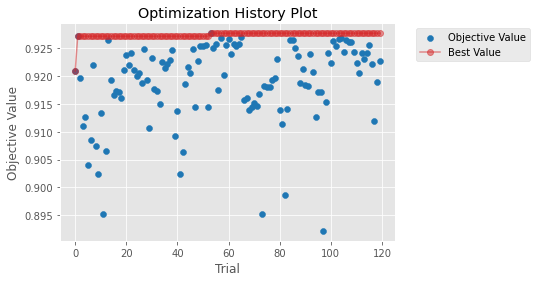

In [180]:
optuna.visualization.matplotlib.plot_optimization_history(study)

In [181]:
study.best_params

{'ourlearning_rate': 0.0033390838162478654,
 'estimators': 1085,
 'sample': 0.8940855161882343,
 'depth': 12,
 'alpha': 0.01840138430387909,
 'lambda': 0.13844447114873107,
 'colsample_bytree': 0.4827328341256603,
 'ourgamma': 0.00158436089401161,
 'childweight': 3}

In [179]:
xgb_optuna=xgboost.XGBClassifier(learning_rate= 0.015135844123869435,n_estimators=1567,subsample= 0.6173942843116965,max_depth=13,min_child_weight=8,
               reg_alpha= 0.11365867642687391,reg_lambda= 0.08535742226335005,colsample_bytree=  0.6498400786834363,
               gamma= 4.644477779282403).fit(x_train_sc,y_train)

In [180]:
train_pred_prob= np.where(pd.DataFrame(xgb_optuna.predict_proba(x_train_sc))[1]>cut_off, 1, 0)
test_pred_prob = np.where(pd.DataFrame(xgb_optuna.predict_proba(x_test_sc))[1]>cut_off, 1, 0)

In [181]:
print('ROC_AUC_Train: ', roc_auc_score(y_train, train_pred_prob))
print('--------------------------------------------------------------------')
print('ROC_AUC_Test: ', roc_auc_score(y_test, test_pred_prob))

ROC_AUC_Train:  0.8771245245519652
--------------------------------------------------------------------
ROC_AUC_Test:  0.8825061274509803


In [182]:
print(classification_report(y_test, test_pred_prob))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       102
           1       0.88      0.92      0.90       128

    accuracy                           0.89       230
   macro avg       0.89      0.88      0.88       230
weighted avg       0.89      0.89      0.89       230



In [183]:
print(confusion_matrix(y_test, test_pred_prob))

[[ 86  16]
 [ 10 118]]


In [184]:
ourscores= cross_val_score(xgb_optuna,x_train_sc,y_train,scoring='roc_auc',n_jobs=-1,cv=10)
print(np.mean(ourscores),np.std(ourscores))
print(ourscores)

0.9248038360941585 0.0414927392110987
[0.94057725 0.94312394 0.93039049 0.96774194 0.95755518 0.81154499
 0.94567063 0.92982456 0.9122807  0.90932868]


In [185]:
xgb_optuna.predict(x_test_sc,validate_features=False)

array([1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0])

### Saving the Model

In [186]:
import joblib

In [187]:
model=joblib.dump(xgb_optuna,'xgb_classifier_optuna.h5')